# All Imports

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import datasets, layers, Sequential, Model
from tensorflow.keras.utils import to_categorical

import os
import glob
import argparse
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

import cv2
# from Computer_Vision.Sobel_Edge_Detection.convolution import convolution
# from Computer_Vision.Sobel_Edge_Detection.gaussian_smoothing import gaussian_blur

import time
import PIL
import imageio
import pickle
from IPython import display
import random

from sklearn.decomposition import PCA 
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils import resample

# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
 

print('\n',
      tf.__version__,'\n',
      np.__version__,'\n',
      pd.__version__)


 2.6.0 
 1.19.5 
 1.1.5


naming convention: \
Train = Real \
D = X,Y stacked (usually) \
SAGAN1 = offspring GAN trained on biased data \
PPO = PPO GAN (Privacy Preserving Offspring GAN) trained on biased data \
PGcB = PG-cGAN trained on biased data \
Syn = Synthetic data \\
Syn_ss = Synthetic data passed through Mendelian hybridizer

# Data Retrival and Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Retrival from .vcf file and .ped file

In [ ]:
# load data
vcf_file = 'HLA.recode.vcf'

# get header
with open(vcf_file,'r') as f_in:
    # skip info
    for line_num in range(252):
        f_in.readline()
    
    line=f_in.readline()
# print(line.strip().split('\t'))

# load genotype
genotype = pd.read_csv(vcf_file, comment='#', sep='\t', names=line.strip().split('\t'))
print('genotype_file shape:', genotype.shape)

genotype_file shape: (7161, 2513)


In [ ]:
genotype

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
0,6,33500639,rs6905127,G,A,100,PASS,AC=363;AF=0.072484;AN=5008;NS=2504;DP=17843;EA...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
1,6,33500853,rs385251,G,A,100,PASS,AC=2541;AF=0.507388;AN=5008;NS=2504;DP=20304;E...,GT,0|0,...,0|1,0|0,0|1,1|0,1|1,0|0,1|1,1|1,1|0,1|0
2,6,33500930,rs55782090,G,C,100,PASS,AC=492;AF=0.0982428;AN=5008;NS=2504;DP=19157;E...,GT,0|0,...,0|0,0|0,0|1,0|0,0|1,0|0,1|1,0|1,0|0,0|0
3,6,33501330,rs453295,T,C,100,PASS,AC=378;AF=0.0754792;AN=5008;NS=2504;DP=18996;E...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
4,6,33501648,rs62405926,A,G,100,PASS,AC=492;AF=0.0982428;AN=5008;NS=2504;DP=20870;E...,GT,0|0,...,0|0,0|0,0|1,0|0,0|1,0|0,1|1,0|1,0|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7156,6,36598209,rs6913530,G,A,100,PASS,AC=1059;AF=0.211462;AN=5008;NS=2504;DP=21764;E...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|1,1|1,0|0
7157,6,36598837,rs9394365,G,C,100,PASS,AC=1126;AF=0.22484;AN=5008;NS=2504;DP=18227;EA...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|1,1|1,0|0
7158,6,36599010,rs4713987,T,C,100,PASS,AC=2404;AF=0.480032;AN=5008;NS=2504;DP=17199;E...,GT,0|0,...,0|0,1|0,0|0,1|0,1|0,0|0,1|0,0|1,1|1,1|1
7159,6,36599596,rs10947615,T,C,100,PASS,AC=1109;AF=0.221446;AN=5008;NS=2504;DP=16708;E...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|1,1|1,0|0


In [ ]:
X_train = genotype.iloc[:, 9:].replace({
    '0|0': 0,
    '0|1': 1,
    '1|0': 2,
    '1|1': 3
}).transpose()
# X_train.shape

In [ ]:
ped_file = 'integrated_call_samples.20130502.ALL.ped'
pedigree = pd.read_csv(ped_file, sep='\t', index_col='Individual ID')

In [ ]:
pedigree['Super Population'] = pedigree['Population']
pedigree['Super Population'] = pedigree['Super Population'].replace({
    'YRI': 'AFR', 'CEU': 'EUR', 'GWD': 'AFR', 'ESN': 'AFR',
    'CHS': 'EAS', 'IBS': 'EUR', 'PJL': 'SAS', 'PUR': 'AMR',
    'CLM': 'AMR', 'BEB': 'SAS', 'CHB': 'EAS', 'PEL': 'AMR',
    'STU': 'SAS', 'MSL': 'AFR', 'JPT': 'EAS', 'KHV': 'EAS',
    'ACB': 'AMR', 'LWK': 'AFR', 'ITU': 'SAS', 'GIH': 'SAS',
    'ASW': 'AMR', 'TSI': 'EUR', 'CDX': 'EAS', 'CHD': 'EAS',
    'GBR': 'EUR', 'MXL': 'AMR', 'FIN': 'EUR' })

In [ ]:
pedigree['Super Population'] = pedigree['Super Population'].replace({
    'EAS': 0,
    'AMR': 1,
    'EUR': 2,
    'AFR': 3,
    'SAS': 4
})
pedigree.head()

,Family ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Children,Other Comments,Super Population
Individual ID,,,,,,,,,,,,,
HG00096,HG00096,0,0,1,0,GBR,unrel,0,0,0,0,0,2
HG00097,HG00097,0,0,2,0,GBR,unrel,0,0,0,0,0,2
HG00098,HG00098,0,0,1,0,GBR,unrel,0,0,0,0,0,2
HG00099,HG00099,0,0,2,0,GBR,unrel,0,0,0,0,0,2
HG00100,HG00100,0,0,2,0,GBR,unrel,0,0,0,0,0,2


In [ ]:
# Use super population as label
Y_train = pedigree.loc[genotype.iloc[:, 9:].columns,:]['Super Population']
# Y_train.head()

In [ ]:
X_train = X_train.loc[Y_train.index, :7159]
print(X_train.shape)
X_train.head()

(2504, 7160)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7120,7121,7122,7123,7124,7125,7126,7127,7128,7129,7130,7131,7132,7133,7134,7135,7136,7137,7138,7139,7140,7141,7142,7143,7144,7145,7146,7147,7148,7149,7150,7151,7152,7153,7154,7155,7156,7157,7158,7159
HG00096,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
HG00097,0,2,2,0,2,0,0,0,0,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,1,0,0,2,2,2,2,...,1,0,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,1,2,2,1,1,1,2,1,1,1,1,1,0,1,1,1,1
HG00099,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,0,3,3,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3,0,0,0,0,3,0,0,3,3,3,0,1,3,3,3,3,0,3,3,3,3
HG00100,0,1,1,0,1,0,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,...,1,0,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,1,0,2,1,1,1,0,0,1,1,1,1,0,1,1,1,1
HG00101,0,3,2,0,2,0,0,0,0,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,0,0,0,2,2,2,2,...,2,0,2,2,0,0,0,0,0,0,2,2,3,3,3,2,2,2,2,0,0,0,0,2,1,0,2,2,2,1,2,2,2,2,2,0,2,2,2,2


In [ ]:
X_train = to_categorical(X_train)
# print(X_train.shape)
# X_train = X_train[:, :7160,:].reshape((X_train.shape[0], 7160, 4))
# print(X_train.shape)
np.save("X_train",X_train)

In [ ]:
print(np.unique(Y_train, return_counts=True))
np.save("Y_train",Y_train)

(array([0, 1, 2, 3, 4]), array([504, 504, 503, 504, 489]))


(array([504.,   0., 504.,   0.,   0., 503.,   0., 504.,   0., 489.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

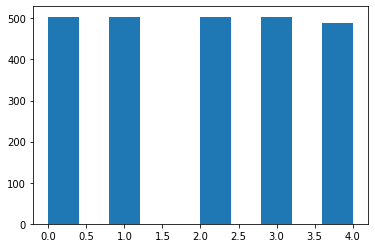

In [ ]:
plt.hist(Y_train)

In [ ]:
!cp X_train.npy /content/drive/MyDrive/X_Shi_Lab/Data_HLA/
!cp Y_train.npy /content/drive/MyDrive/X_Shi_Lab/Data_HLA/


Text(0.5, 1.0, 'label: 2')

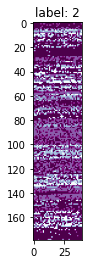

In [ ]:
plt.colorbar =  cmap=plt.get_cmap("BuPu_r")
plt.imshow(np.argmax(X_train[0], axis=-1).reshape(179,40,), cmap=plt.get_cmap("BuPu_r"))
plt.title('label: {}'.format(Y_train[0]))

## Whole Real Dataset

In [ ]:
X_real_cat = np.load('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/X_train.npy')
X_real = np.argmax(X_real_cat, axis=2) 
Y_real = np.load('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/Y_train.npy')
Y_real = Y_real.reshape((2504,1))
D_real = np.hstack((X_real,Y_real)) 

D_columns = np.load('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/column.npy')
D_columns = D_columns.tolist()
D_real = pd.DataFrame(D_real, columns=D_columns)
D_real["GAN SYN Label"]=D_real["GAN SYN Label"].replace({   
    0: 'EAS',
    1 : 'AMR',
    2 : 'EUR',
    3 : 'AFR',
    4 : 'SAS'})
# df_real = D_real.drop('GAN SYN Label', axis= 1)
# df_real_corr=df_real.corr(method='pearson')
# plt.imshow(df_real_corr, cmap=plt.get_cmap("BuPu_r"))
# np.save("df_real_corr.npy",df_real_corr)
# !cp df_real_corr.npy "/content/drive/MyDrive/X_Shi_Lab/Data_HLA/"

In [ ]:
# Sort all population
X_real_EAS = np.empty(shape=(0,7160))
Y_real_EAS = np.empty(shape=(0,1))
X_real_AMR = np.empty(shape=(0,7160))
Y_real_AMR = np.empty(shape=(0,1))
X_real_EUR = np.empty(shape=(0,7160))
Y_real_EUR = np.empty(shape=(0,1))
X_real_AFR = np.empty(shape=(0,7160))
Y_real_AFR = np.empty(shape=(0,1))
X_real_SAS = np.empty(shape=(0,7160))
Y_real_SAS = np.empty(shape=(0,1))

for i in range (X_real.shape[0]):
  if D_real.iloc[i][7160]== 'EAS':
    X_real_EAS= np.vstack((X_real_EAS,X_real[i]))
    Y_real_EAS= np.vstack((Y_real_EAS,Y_real[i])) #This is how stupid I am ! 
  if D_real.iloc[i][7160]== 'AMR':
    X_real_AMR= np.vstack((X_real_AMR,X_real[i]))
    Y_real_AMR= np.vstack((Y_real_AMR,Y_real[i]))
  if D_real.iloc[i][7160]== 'EUR':
    X_real_EUR= np.vstack((X_real_EUR,X_real[i]))
    Y_real_EUR= np.vstack((Y_real_EUR,Y_real[i]))
  if D_real.iloc[i][7160]== 'AFR':
    X_real_AFR= np.vstack((X_real_AFR,X_real[i]))
    Y_real_AFR= np.vstack((Y_real_AFR,Y_real[i]))
  if D_real.iloc[i][7160]== 'SAS':
    X_real_SAS= np.vstack((X_real_SAS,X_real[i]))
    Y_real_SAS= np.vstack((Y_real_SAS,Y_real[i]))


# all of these are not one hot encoded yet 

D_real_EAS = np.hstack((X_real_EAS,Y_real_EAS))
D_real_AMR = np.hstack((X_real_AMR,Y_real_AMR))
D_real_EUR = np.hstack((X_real_EUR,Y_real_EUR))
D_real_AFR = np.hstack((X_real_AFR,Y_real_AFR))
D_real_SAS = np.hstack((X_real_SAS,Y_real_SAS))


np.save("D_real_EAS.npy",D_real_EAS)
!cp D_real_EAS.npy "/content/drive/MyDrive/X_Shi_Lab/Data_HLA/"
np.save("D_real_AMR.npy",D_real_AMR)
!cp D_real_AMR.npy "/content/drive/MyDrive/X_Shi_Lab/Data_HLA/"
np.save("D_real_EUR.npy",D_real_EUR)
!cp D_real_EUR.npy "/content/drive/MyDrive/X_Shi_Lab/Data_HLA/"
np.save("D_real_AFR.npy",D_real_AFR)
!cp D_real_AFR.npy "/content/drive/MyDrive/X_Shi_Lab/Data_HLA/"
np.save("D_real_SAS.npy",D_real_SAS)
!cp D_real_SAS.npy "/content/drive/MyDrive/X_Shi_Lab/Data_HLA/"
# D_real_EAS = np.load('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/D_real_EAS.npy')
# D_real_AMR = np.load('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/D_real_AMR.npy')
# D_real_EUR = np.load('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/D_real_EUR.npy')
# D_real_AFR = np.load('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/D_real_AFR.npy')
# D_real_SAS = np.load('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/D_real_SAS.npy')

## Creating Biased Dataset

In [ ]:
#EAS
t_list=[]
# for i in range(100):
while len(t_list) < 100:
  r=random.randint(0,503)
  if r not in t_list: t_list.append(r)
D_t_real_EAS = np.empty(shape=(0,D_real_EAS.shape[1]))
for i in t_list:
  D_t_real_EAS = np.vstack((D_t_real_EAS,D_real_EAS[i]))
#AMR
t_list=[]
# for i in range(100):
while len(t_list) < 100:
  r=random.randint(0,503)
  if r not in t_list: t_list.append(r)
D_t_real_AMR = np.empty(shape=(0,D_real_AMR.shape[1]))
for i in t_list:
  D_t_real_AMR = np.vstack((D_t_real_AMR,D_real_AMR[i]))
#EUR
t_list=[]
# for i in range(100):
while len(t_list) < 100:
  r=random.randint(0,502)
  if r not in t_list: t_list.append(r)
D_t_real_EUR = np.empty(shape=(0,D_real_EUR.shape[1]))
for i in t_list:
  D_t_real_EUR = np.vstack((D_t_real_EUR,D_real_EUR[i]))
#AFR
t_list=[]
# for i in range(100):
while len(t_list) < 100:
  r=random.randint(0,503)
  if r not in t_list: t_list.append(r)
D_t_real_AFR = np.empty(shape=(0,D_real_AFR.shape[1]))
for i in t_list:
  D_t_real_AFR = np.vstack((D_t_real_AFR,D_real_AFR[i]))
#SAS
t_list=[]
# for i in range(100):
while len(t_list) < 100:
  r=random.randint(0,488) 
  if r not in t_list: t_list.append(r)
D_t_real_SAS = np.empty(shape=(0,D_real_SAS.shape[1]))
for i in t_list:
  D_t_real_SAS = np.vstack((D_t_real_SAS,D_real_SAS[i]))

## Make small blocks for Mendelian hybridizer's input 

In [ ]:
D_t_real_EAS_bb1=D_t_real_EAS[:,0:1000]
D_t_real_EAS_bb2=D_t_real_EAS[:,1000:2000]
D_t_real_EAS_bb3=D_t_real_EAS[:,2000:3000]
D_t_real_EAS_bb4=D_t_real_EAS[:,3000:4000]
D_t_real_EAS_bb5=D_t_real_EAS[:,4000:5000]
D_t_real_EAS_bb6=D_t_real_EAS[:,5000:6000]
D_t_real_EAS_bb7=D_t_real_EAS[:,6000:7161]

# D_t_real_AMR_bb1=D_t_real_AMR[:,0:1000]
# D_t_real_AMR_bb2=D_t_real_AMR[:,1000:2000]
# D_t_real_AMR_bb3=D_t_real_AMR[:,2000:3000]
# D_t_real_AMR_bb4=D_t_real_AMR[:,3000:4000]
# D_t_real_AMR_bb5=D_t_real_AMR[:,4000:5000]
# D_t_real_AMR_bb6=D_t_real_AMR[:,5000:6000]
# D_t_real_AMR_bb7=D_t_real_AMR[:,6000:7161]

# D_t_real_EUR_bb1=D_t_real_EUR[:,0:1000]
# D_t_real_EUR_bb2=D_t_real_EUR[:,1000:2000]
# D_t_real_EUR_bb3=D_t_real_EUR[:,2000:3000]
# D_t_real_EUR_bb4=D_t_real_EUR[:,3000:4000]
# D_t_real_EUR_bb5=D_t_real_EUR[:,4000:5000]
# D_t_real_EUR_bb6=D_t_real_EUR[:,5000:6000]
# D_t_real_EUR_bb7=D_t_real_EUR[:,6000:7161]

D_t_real_AFR_bb1=D_t_real_AFR[:,0:1000]
D_t_real_AFR_bb2=D_t_real_AFR[:,1000:2000]
D_t_real_AFR_bb3=D_t_real_AFR[:,2000:3000]
D_t_real_AFR_bb4=D_t_real_AFR[:,3000:4000]
D_t_real_AFR_bb5=D_t_real_AFR[:,4000:5000]
D_t_real_AFR_bb6=D_t_real_AFR[:,5000:6000]
D_t_real_AFR_bb7=D_t_real_AFR[:,6000:7161]

D_t_real_SAS_bb1=D_t_real_SAS[:,0:1000]
D_t_real_SAS_bb2=D_t_real_SAS[:,1000:2000]
D_t_real_SAS_bb3=D_t_real_SAS[:,2000:3000]
D_t_real_SAS_bb4=D_t_real_SAS[:,3000:4000]
D_t_real_SAS_bb5=D_t_real_SAS[:,4000:5000]
D_t_real_SAS_bb6=D_t_real_SAS[:,5000:6000]
D_t_real_SAS_bb7=D_t_real_SAS[:,6000:]

# Offspring GAN

## Common Parameters and functions

In [ ]:
noise_dim = 100
genotype_len = 7160
channels = 4
genotype_shape = (genotype_len, channels)
num_classes = 5
lrelu_alpha = 0.2
# batch_size=32 #defined later 

In [ ]:
'''https://github.com/IShengFang/SpectralNormalizationKeras'''

from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import InputSpec
import tensorflow.keras.backend as K

class ClipConstraint(constraints.Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
      self.clip_value = clip_value
  
    # clip model weights to hypercube
    def __call__(self, weights):
      return K.clip(weights, -self.clip_value, self.clip_value)
  
    # get the config
    def get_config(self):
      return {'clip_value': self.clip_value}

class ConvSN1D(tf.keras.layers.Conv1D):
    
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                 initializer=initializers.RandomNormal(0, 1),
                 name='sn',
                 trainable=False)
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
        
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if not training:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv1d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
      super().__init__()
      self.channels = kwargs['channels']
      self.one_eights_conv = None
      self.one_second_conv = None
      self.max_pooling_0 = None
      self.max_pooling_1 = None
      self.attention = None
      self.final_conv = None
      pass

    def build(self, input_shape):
      if self.one_eights_conv is None:
        self.one_eights_conv = layers.Conv1D(self.channels // 8, 1, strides=1, padding='same',
                                kernel_initializer='glorot_uniform')
      if self.one_second_conv is None:
        self.one_second_conv = layers.Conv1D(self.channels // 2, 1, strides=1, padding='same',
                                kernel_initializer='glorot_uniform')
      if self.max_pooling_0 is None:
        self.max_pooling_0 = layers.MaxPooling1D(pool_size=2, strides=2, padding='same')
      if self.max_pooling_1 is None:
        self.max_pooling_1 = layers.MaxPooling1D(pool_size=2, strides=2, padding='same')
      if self.attention is None:
        self.attention = layers.Attention(use_scale=True)
      if self.final_conv is None:
        self.final_conv = ConvSN1D(self.channels, 1, strides=1)

    def call(self, x, training=None):
      batch_size, width, num_channels = x.get_shape().as_list()
      g = self.one_eights_conv(x, training=training)  # [bs, w, c']
      f = self.max_pooling_0(g)
      h = self.one_second_conv(x, training=training)  # [bs, w, c]
      h = self.max_pooling_1(h)
      o = self.attention([g, h, f])
      
      o = self.final_conv(o, training=training)
      x = o + x
      return x

class GlobalSumPooling1D(tf.keras.layers.Layer):
	def __init__(self, **kwargs):
		super().__init__()
		pass

	def call(self, inputs):
		return K.sum(inputs, axis=1)


## Mendelian hybridizer Def


In [ ]:
rng = np.random.default_rng()
def shuffleR(block):
  shuffled = block
  rng.shuffle(shuffled,axis=0)
  return shuffled
#Blocks 

In [ ]:
def semi_block_synR(block:np.array, fold:int):
  semi_block_syn = block
  for i in range (1,fold): 
    semi_block_syn = np.vstack((semi_block_syn, shuffleR(block)))
  return semi_block_syn

In [ ]:
def semi_syn_R(blocks:list,fold:int):
  semi_syn= np.empty(shape=(fold*blocks[0].shape[0],0))
  for block in blocks:
    semi_syn = np.hstack(( semi_syn, semi_block_synR(block=block,fold=fold) )) 
  return semi_syn

## first Mendelian hybridizer 

In [ ]:
#EAS
D_t_SemiSyn_EAS_1 = semi_syn_R((D_t_real_EAS_bb1,
                               D_t_real_EAS_bb2,
                               D_t_real_EAS_bb3,
                               D_t_real_EAS_bb4,
                               D_t_real_EAS_bb5,
                               D_t_real_EAS_bb6,
                               D_t_real_EAS_bb7),
                              4)
D_t_semisyn_EAS_1 = np.vstack((D_t_real_EAS,D_t_SemiSyn_EAS_1))
# #AMR
# D_t_SemiSyn_AMR_1 = semi_syn_R((D_t_real_AMR_bb1,
#                                D_t_real_AMR_bb2,
#                                D_t_real_AMR_bb3,
#                                D_t_real_AMR_bb4,
#                                D_t_real_AMR_bb5,
#                                D_t_real_AMR_bb6,
#                                D_t_real_AMR_bb7),
#                               4)
# D_t_semisyn_AMR_1 = np.vstack((D_t_real_AMR,D_t_SemiSyn_AMR_1))
# #EUR
# D_t_SemiSyn_EUR_1 = semi_syn_R((D_t_real_EUR_bb1,
#                                D_t_real_EUR_bb2,
#                                D_t_real_EUR_bb3,
#                                D_t_real_EUR_bb4,
#                                D_t_real_EUR_bb5,
#                                D_t_real_EUR_bb6,
#                                D_t_real_EUR_bb7),
#                               4)
# D_t_semisyn_EUR_1 = np.vstack((D_t_real_EUR,D_t_SemiSyn_EUR_1))

#AFR
D_t_SemiSyn_AFR_1 = semi_syn_R((D_t_real_AFR_bb1,
                               D_t_real_AFR_bb2,
                               D_t_real_AFR_bb3,
                               D_t_real_AFR_bb4,
                               D_t_real_AFR_bb5,
                               D_t_real_AFR_bb6,
                               D_t_real_AFR_bb7),
                              4)
D_t_semisyn_AFR_1 = np.vstack((D_t_real_AFR,D_t_SemiSyn_AFR_1))
#SAS
D_t_SemiSyn_SAS_1 = semi_syn_R((D_t_real_SAS_bb1,
                               D_t_real_SAS_bb2,
                               D_t_real_SAS_bb3,
                               D_t_real_SAS_bb4,
                               D_t_real_SAS_bb5,
                               D_t_real_SAS_bb6,
                               D_t_real_SAS_bb7),
                              4)
D_t_semisyn_SAS_1 = np.vstack((D_t_real_SAS,D_t_SemiSyn_SAS_1))

np.save("D_t_semisyn_EAS_1.npy",D_t_semisyn_EAS_1)
!cp D_t_semisyn_EAS_1.npy "/content/drive/MyDrive/X_Shi_Lab/Data_HLA/"
np.save("D_t_semisyn_AMR_1.npy",D_t_semisyn_AMR_1)
!cp D_t_semisyn_AMR_1.npy "/content/drive/MyDrive/X_Shi_Lab/Data_HLA/"
np.save("D_t_semisyn_EUR_1.npy",D_t_semisyn_EUR_1)
!cp D_t_semisyn_EUR_1.npy "/content/drive/MyDrive/X_Shi_Lab/Data_HLA/"
np.save("D_t_semisyn_AFR_1.npy",D_t_semisyn_AFR_1)
!cp D_t_semisyn_AFR_1.npy "/content/drive/MyDrive/X_Shi_Lab/Data_HLA/"
np.save("D_t_semisyn_SAS_1.npy",D_t_semisyn_SAS_1)
!cp D_t_semisyn_SAS_1.npy "/content/drive/MyDrive/X_Shi_Lab/Data_HLA/"

## Use Mendelian hybridizer output as input of Discriminator

In [ ]:
D_t_semisyn_1 = np.vstack((D_t_semisyn_EAS_1,D_real_AMR,D_real_EUR,D_t_semisyn_AFR_1,D_t_semisyn_SAS_1))
X = D_t_semisyn_1[:,0:7160]
X = to_categorical(X)
Y = D_t_semisyn_1[:,-1]
dataset = (X,Y)

## Generator

In [ ]:
# tf.keras.backend.clear_session()

In [ ]:
def make_generator_model():
  noise = layers.Input(shape=(noise_dim,))
    
  label = layers.Input(shape=(1,))
  label_embedding = layers.Flatten()(layers.Embedding(num_classes, noise_dim)(label))

  model_input = layers.multiply([noise, label_embedding])

  x = layers.Dense(1790 * 256, use_bias=False, input_shape=(noise_dim, ))(model_input)
  
  
  x = layers.Reshape((1790, 256))(x)
  x = layers.Dropout(0.3)(x)
  x = layers.BatchNormalization(epsilon=2e-5, momentum=9e-1)(x)
  # x = tf.nn.gelu(x,approximate=False)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Conv1D(256, 7,
                      strides=1,
                      padding='same', use_bias=False, kernel_initializer='glorot_uniform')(x)
  x = layers.UpSampling1D(2)(x)
  x = layers.BatchNormalization(epsilon=2e-5, momentum=9e-1)(x)
  # x = tf.nn.gelu(x,approximate=False)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.4)(x)
  
  x = layers.Conv1D(128, 5,
                      strides=1,
                      padding='same', use_bias=False, kernel_initializer='glorot_uniform')(x)
  x = layers.UpSampling1D(2)(x)
  x = layers.BatchNormalization(epsilon=2e-5, momentum=9e-1)(x)
  # x = tf.nn.gelu(x,approximate=False)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.5)(x)



  x = layers.Conv1D(channels, 5,
                               strides=1,
                               padding='same',
                               activation='softmax'
                               )(x)

  return Model([noise, label], x)

# plot_model(make_generator_model(), show_shapes=True, show_layer_names=True)

In [ ]:
tf.keras.backend.clear_session()
generator = make_generator_model()

noise = tf.random.normal([1, 100])
label = np.random.randint(0, 4, (1, ))
generated_genotype = generator([noise, label], training=False)

# plt.imshow(np.argmax(generated_genotype, axis=2).reshape(179,40,), cmap=plt.get_cmap("BuPu_r"))
# plt.title('label: {}'.format(label))

In [ ]:
generator.summary()
generated_genotype

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       500         ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 flatten (Flatten)              (None, 100)          0           ['embedding[0][0]']              
                                                                                              

<tf.Tensor: shape=(1, 7160, 4), dtype=float32, numpy=
array([[[0.249972  , 0.25001547, 0.2500359 , 0.24997665],
        [0.24994954, 0.24997212, 0.25003994, 0.25003836],
        [0.24998331, 0.24994254, 0.25004363, 0.2500305 ],
        ...,
        [0.2499685 , 0.25002283, 0.2500021 , 0.25000662],
        [0.24995899, 0.25002426, 0.25002003, 0.24999674],
        [0.25000095, 0.24997878, 0.25002298, 0.24999727]]], dtype=float32)>

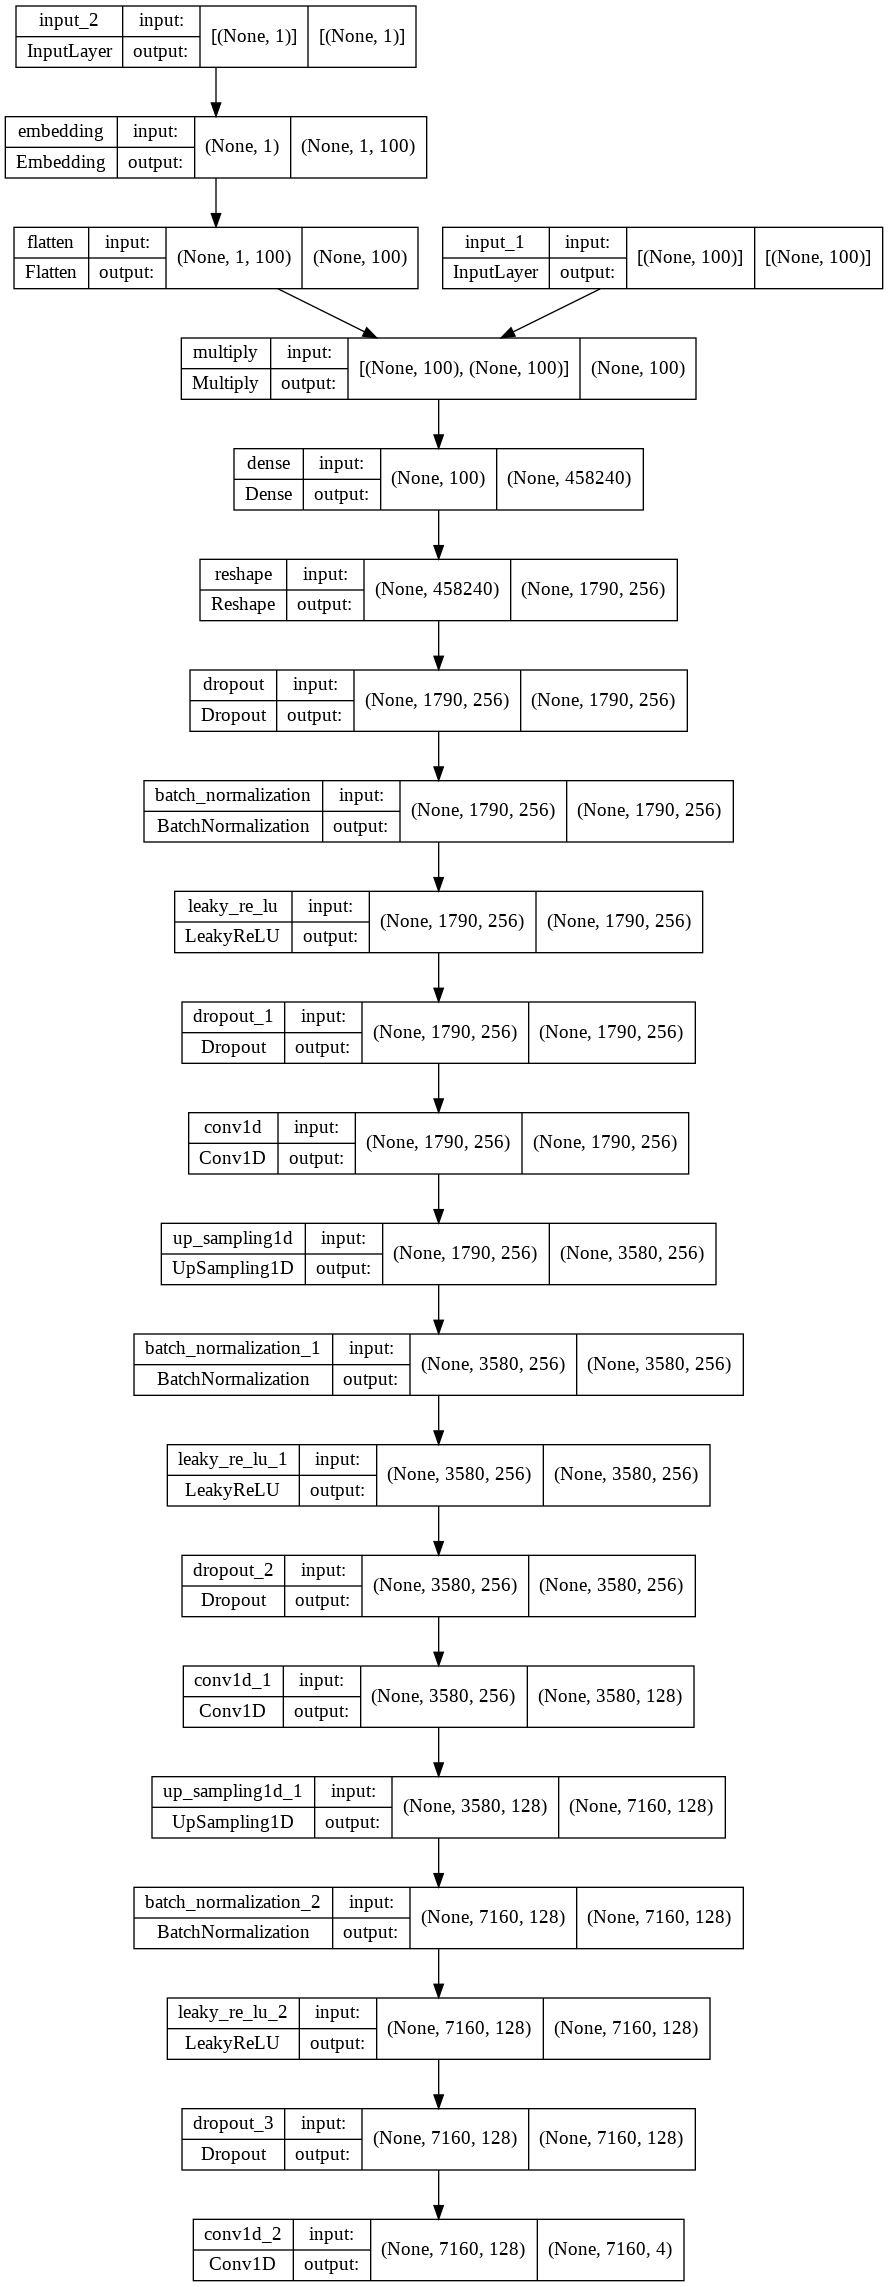

In [ ]:
tf.keras.utils.plot_model(
    generator, to_file='Generator.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

## Discriminator

In [ ]:
def make_discriminator_model():
  const = ClipConstraint(0.01)
  genotype = layers.Input(shape=genotype_shape)
  label = layers.Input(shape=(1, ), dtype='int32')

  flat_genotype = layers.Flatten()(genotype)
  label_embedding = layers.Flatten()(layers.Embedding(num_classes, genotype_len * channels)(label))

  model_input = layers.multiply([flat_genotype, label_embedding])
  model_input = layers.Reshape((genotype_len, channels))(model_input)

  x = layers.LeakyReLU()(model_input)
  x = layers.Dropout(0.3)(x)

  x = layers.Conv1D(64, 5, strides=2, padding='same', kernel_constraint=const,
                              kernel_initializer='glorot_uniform')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.3)(x)
 
  
  x = layers.Conv1D(128, 7, strides=2, padding='same', kernel_constraint=const,
                              kernel_initializer='glorot_uniform')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.3)(x)
  
  x = layers.Flatten()(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(512, kernel_initializer='glorot_uniform')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dense(1, kernel_initializer='glorot_uniform')(x)

  return Model([genotype, label], x)


In [ ]:
# Use the (as yet untrained) discriminator 
# to classify the generated images as real or fake.
discriminator = make_discriminator_model()

decision = discriminator([generated_genotype, label])
print(decision)

tf.Tensor([[0.00090181]], shape=(1, 1), dtype=float32)


In [ ]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 7160, 4)]    0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 28640)     143200      ['input_4[0][0]']                
                                                                                                  
 flatten_1 (Flatten)            (None, 28640)        0           ['input_3[0][0]']                
                                                                                            

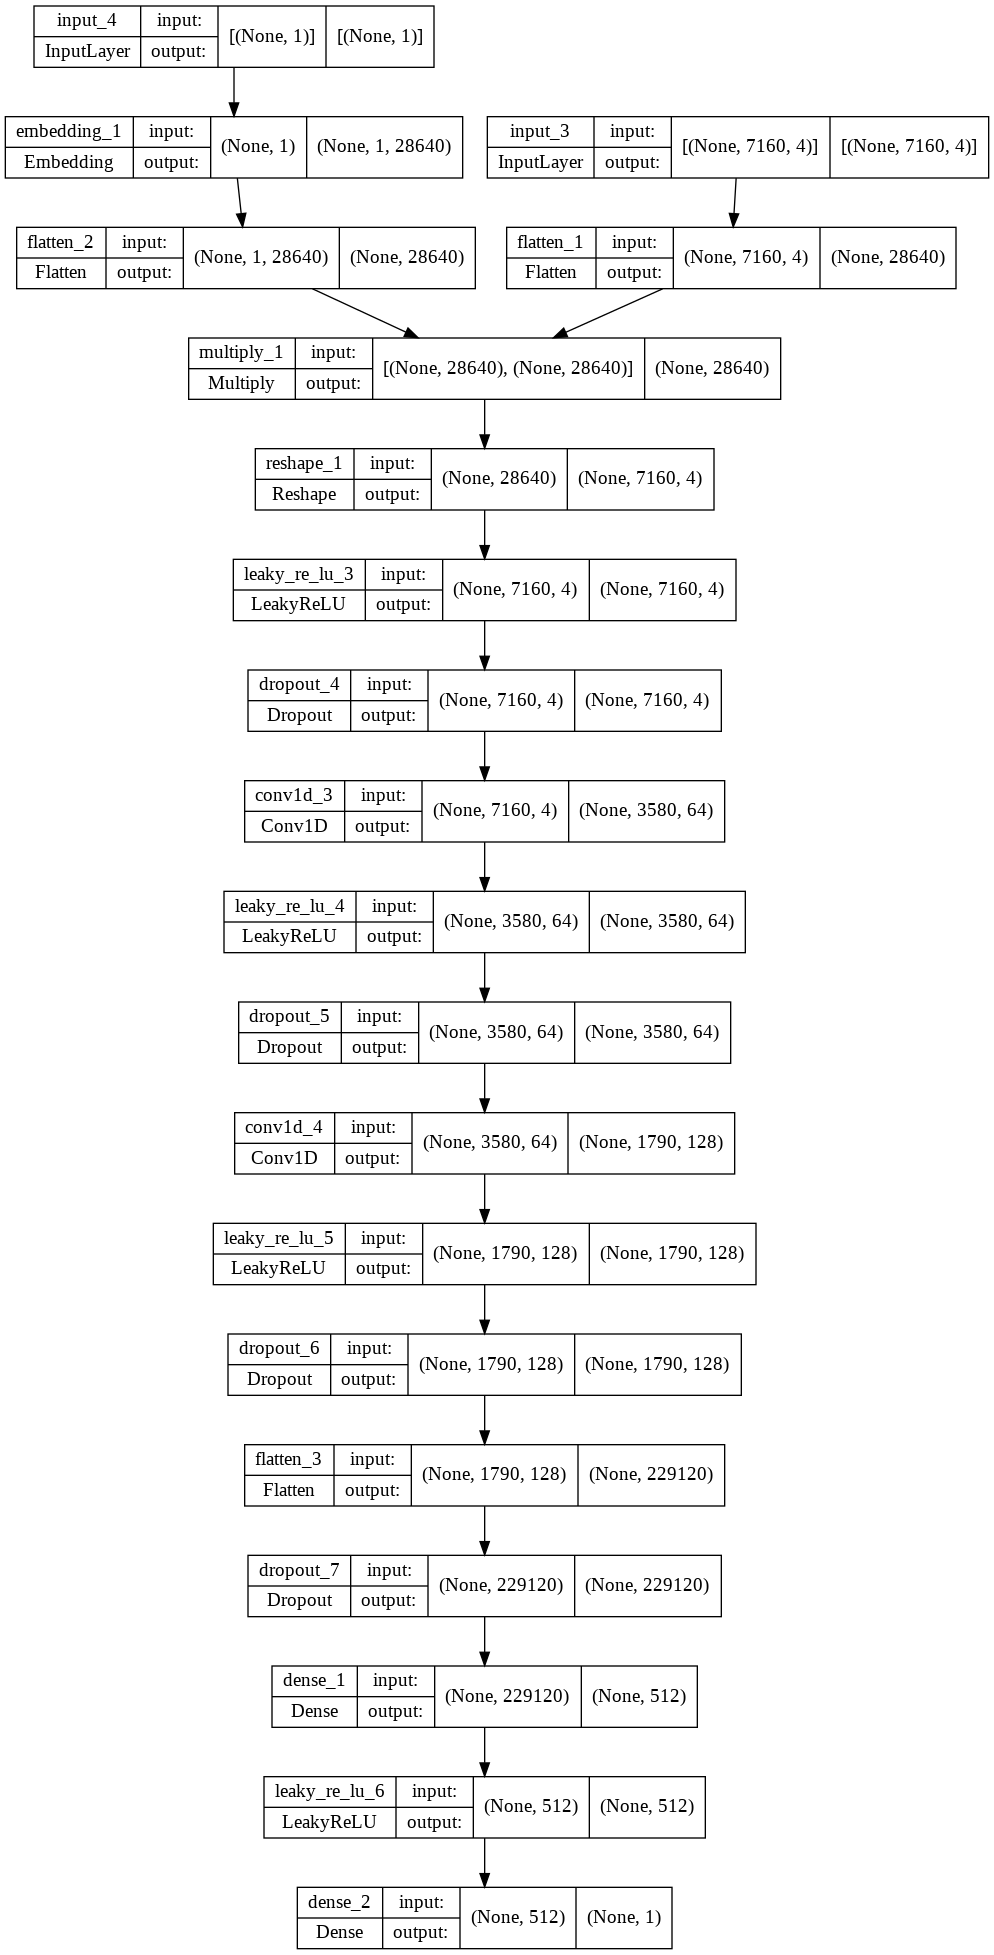

In [ ]:
tf.keras.utils.plot_model(
    discriminator, to_file='Denerator.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

## Loss

Do not use wasserstein loss here, it doesn't help. \

In [ ]:
# Hinge loss
hinge_loss = tf.keras.losses.Hinge()
def discriminator_loss(real_output, fake_output):
    real_loss = hinge_loss(tf.ones_like(real_output), real_output)
    fake_loss = hinge_loss(tf.math.negative(tf.ones_like(fake_output)), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss 
def generator_loss(fake_output):
    return hinge_loss(tf.ones_like(fake_output), fake_output)

# def discriminator_accuracy(real_output, fake_output):
#     real_acc = tf.keras.metrics.binary_accuracy(tf.ones_like(real_output), real_output)
#     fake_acc = tf.keras.metrics.binary_accuracy(tf.math.negative(tf.ones_like(fake_output)), fake_output)
#     return real_acc, fake_acc

## Optimizer

In [ ]:
BETA_1 = 0.5
BETA_2 = 0.9
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=BETA_1, beta_2=BETA_2, amsgrad=True)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=BETA_1, beta_2=BETA_2, amsgrad=True)

## Train Step and Save image, check points

In [ ]:
num_examples_to_generate = num_classes

In [ ]:
noise = tf.random.normal([num_examples_to_generate, noise_dim])
label = np.array([0,
                  1,
                  2,
                  3,
                  4,])
seed = [noise, label]

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch_size, genotypes, labels):
    # noise = tf.random.normal([batch_size, noise_dim])
    # train disc
    for _ in range(4):
        noise = tf.random.normal([batch_size, noise_dim])
        with tf.GradientTape() as disc_tape:
          generated_genotypes = generator([noise, labels], training=False)

          real_output = discriminator([genotypes, labels], training=True)
          fake_output = discriminator([generated_genotypes, labels], training=True)
          
          disc_loss = discriminator_loss(real_output, fake_output) 
          
          gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # train both
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_genotypes = generator([noise, labels], training=True)

        real_output = discriminator([genotypes, labels], training=True)
        fake_output = discriminator([generated_genotypes, labels], training=True)
        
        gen_loss = generator_loss(fake_output) 
        disc_loss = discriminator_loss(real_output, fake_output) 
        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    plt.figure()
    for i in range(predictions.shape[0]):
        plt.subplot(1, 5, i + 1)
        plt.imshow(np.argmax(predictions[i,:,:],axis=1).reshape(179,40), cmap=plt.get_cmap("BuPu_r"))
        plt.title('label: {}'.format(test_input[1][i]))
        plt.axis('off')
  
    plt.savefig('/content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/m0t1/full-image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
def train(dataset, epochs, batch_size):
    gen_loss_log, disc_loss_log = [], []

    for epoch in range(epochs):
        start = time.time()
        
        # shuffle and batch the data
        train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(
            X.shape[0]).batch(batch_size, drop_remainder=True)

        # gen_loss_list, disc_loss_list = [], []
        for genotype_batch, label_batch in train_dataset:
            gen_loss, disc_loss = train_step(batch_size, genotype_batch, label_batch)

        # append loss of last batch
        gen_loss_log.append(gen_loss.numpy())
        disc_loss_log.append(disc_loss.numpy())

        # Produce images for the GIF as we go
        if (epoch + 1) % 25 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

        # Save the model 
        if (epoch + 1) % 25 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('gen_loss: {}, disc_loss: {}'.format(gen_loss.numpy(), disc_loss.numpy()))
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    return gen_loss_log, disc_loss_log

## Training

In [ ]:
# !mkdir "/content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1"
# !mkdir "/content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/m0t1"

# !mkdir "/content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/m0t1/tc"
# !mkdir "/content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/m0t1/model"
# !mkdir "/content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/m0t1/images"

In [ ]:
checkpoint_dir = "/content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/m0t1/tc"
checkpoint_prefix = os.path.join(checkpoint_dir, "full")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
predictions = generator(seed, training=False)
plt.figure()
for i in range(predictions.shape[0]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.argmax(predictions[i,:,:],axis=1).reshape(179,40), cmap=plt.get_cmap("BuPu_r"))
    plt.title('label: {}'.format(seed[1][i]))

Train at least 600 epochs to get fairly good results \
All results for comparison are done in 850 epochs. \
Training was done in GPU of google colab 

In [ ]:
EPOCHS = 850
gen_loss_log, disc_loss_log = train(dataset, epochs=EPOCHS, batch_size=32)
checkpoint.save(file_prefix=checkpoint_prefix)

In Google collab free tier GPU it will not run all 850 epochs in one go, \
you would need to it in multiple session using  checkpoints that is saved from last session.\
This took me 6 different sessions, hence for the 850th epoch it is named as m0t6c12. \
PPO GAN was trained on HPC, so it happened in one session and 850th epoch is named as m0t1c34. \


## Trained Generator Output

In [ ]:
# load checkpoint
checkpoint_dir = "/content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/m0t6/tc"
checkpoint_prefix = os.path.join(checkpoint_dir, "full")
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
checkpoint.restore('/content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/m0t6/tc/full-12')

In [ ]:
num_simulated = 2507 # reduce this number if it takes longer but for better approximation of probability distribution bigger number works better. 
# try 500 above it gives fairly similar result 
# generator
SynX_SAGAN1_m0t6c12 = np.empty((0, 7160), int)
SynY_SAGAN1_m0t6c12  = np.empty((0, 1), int)
for i in range(num_simulated):
    noise = tf.random.normal([1, noise_dim])
    # noise = tf.random.uniform([1, noise_dim])
    labels = np.random.randint(low=0, high=5, size=(1, ))


    genotypes = generator([noise, labels], training=False)

    SynX_SAGAN1_m0t6c12  = np.vstack((SynX_SAGAN1_m0t6c12 , np.argmax(genotypes, axis=2)))
    SynY_SAGAN1_m0t6c12  = np.vstack((SynY_SAGAN1_m0t6c12 , labels))

In [ ]:
np.save("SynX_SAGAN1_m0t6c12",SynX_SAGAN1_m0t6c12)
np.save("SynY_SAGAN1_m0t6c12",SynY_SAGAN1_m0t6c12)
!cp SynX_SAGAN1_m0t6c12.npy /content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/SyntheticData/m0t6c12/
!cp SynY_SAGAN1_m0t6c12.npy /content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/SyntheticData/m0t6c12/

## Use trained Generator's output as input of second Mendelian hybridizer

In [ ]:
#sort by population
SynX_SAGAN1_m0t6c12_EAS = np.empty(shape=(0,7160))
SynY_SAGAN1_m0t6c12_EAS = np.empty(shape=(0,1))
SynX_SAGAN1_m0t6c12_AMR = np.empty(shape=(0,7160))
SynY_SAGAN1_m0t6c12_AMR = np.empty(shape=(0,1))
SynX_SAGAN1_m0t6c12_EUR = np.empty(shape=(0,7160))
SynY_SAGAN1_m0t6c12_EUR = np.empty(shape=(0,1))
SynX_SAGAN1_m0t6c12_AFR = np.empty(shape=(0,7160))
SynY_SAGAN1_m0t6c12_AFR = np.empty(shape=(0,1))
SynX_SAGAN1_m0t6c12_SAS = np.empty(shape=(0,7160))
SynY_SAGAN1_m0t6c12_SAS = np.empty(shape=(0,1))
for i in range (SynX_SAGAN1_m0t6c12.shape[0]):
  if SynD_SAGAN1_m0t6c12.iloc[i][7160]== 0: #'EAS':
    SynX_SAGAN1_m0t6c12_EAS= np.vstack((SynX_SAGAN1_m0t6c12_EAS,SynX_SAGAN1_m0t6c12[i]))
    SynY_SAGAN1_m0t6c12_EAS= np.vstack((SynY_SAGAN1_m0t6c12_EAS,SynY_SAGAN1_m0t6c12[i])) #This is how stupid I am ! 
  if SynD_SAGAN1_m0t6c12.iloc[i][7160]== 1: #'AMR':
    SynX_SAGAN1_m0t6c12_AMR= np.vstack((SynX_SAGAN1_m0t6c12_AMR,SynX_SAGAN1_m0t6c12[i]))
    SynY_SAGAN1_m0t6c12_AMR= np.vstack((SynY_SAGAN1_m0t6c12_AMR,SynY_SAGAN1_m0t6c12[i]))
  if SynD_SAGAN1_m0t6c12.iloc[i][7160]==2: #'EUR':
    SynX_SAGAN1_m0t6c12_EUR= np.vstack((SynX_SAGAN1_m0t6c12_EUR,SynX_SAGAN1_m0t6c12[i]))
    SynY_SAGAN1_m0t6c12_EUR= np.vstack((SynY_SAGAN1_m0t6c12_EUR,SynY_SAGAN1_m0t6c12[i]))
  if SynD_SAGAN1_m0t6c12.iloc[i][7160]==3: #'AFR':
    SynX_SAGAN1_m0t6c12_AFR= np.vstack((SynX_SAGAN1_m0t6c12_AFR,SynX_SAGAN1_m0t6c12[i]))
    SynY_SAGAN1_m0t6c12_AFR= np.vstack((SynY_SAGAN1_m0t6c12_AFR,SynY_SAGAN1_m0t6c12[i]))
  if SynD_SAGAN1_m0t6c12.iloc[i][7160]==4: #'SAS':
    SynX_SAGAN1_m0t6c12_SAS= np.vstack((SynX_SAGAN1_m0t6c12_SAS,SynX_SAGAN1_m0t6c12[i]))
    SynY_SAGAN1_m0t6c12_SAS= np.vstack((SynY_SAGAN1_m0t6c12_SAS,SynY_SAGAN1_m0t6c12[i]))

SynD_SAGAN1_m0t6c12_EAS = np.hstack((SynX_SAGAN1_m0t6c12_EAS,SynY_SAGAN1_m0t6c12_EAS))
SynD_SAGAN1_m0t6c12_AMR = np.hstack((SynX_SAGAN1_m0t6c12_AMR,SynY_SAGAN1_m0t6c12_AMR))
SynD_SAGAN1_m0t6c12_EUR = np.hstack((SynX_SAGAN1_m0t6c12_EUR,SynY_SAGAN1_m0t6c12_EUR))
SynD_SAGAN1_m0t6c12_AFR = np.hstack((SynX_SAGAN1_m0t6c12_AFR,SynY_SAGAN1_m0t6c12_AFR))
SynD_SAGAN1_m0t6c12_SAS = np.hstack((SynX_SAGAN1_m0t6c12_SAS,SynY_SAGAN1_m0t6c12_SAS))

In [ ]:
SynD_SAGAN1_m0t6c12_EAS_bb1=SynD_SAGAN1_m0t6c12_EAS[:,0:1000]
SynD_SAGAN1_m0t6c12_EAS_bb2=SynD_SAGAN1_m0t6c12_EAS[:,1000:2000]
SynD_SAGAN1_m0t6c12_EAS_bb3=SynD_SAGAN1_m0t6c12_EAS[:,2000:3000]
SynD_SAGAN1_m0t6c12_EAS_bb4=SynD_SAGAN1_m0t6c12_EAS[:,3000:4000]
SynD_SAGAN1_m0t6c12_EAS_bb5=SynD_SAGAN1_m0t6c12_EAS[:,4000:5000]
SynD_SAGAN1_m0t6c12_EAS_bb6=SynD_SAGAN1_m0t6c12_EAS[:,5000:6000]
SynD_SAGAN1_m0t6c12_EAS_bb7=SynD_SAGAN1_m0t6c12_EAS[:,6000:7161]
#do same for others
SynD_SAGAN1_m0t6c12_SemiSyn_EAS = semi_syn_R((SynD_SAGAN1_m0t6c12_EAS_bb1,
                               SynD_SAGAN1_m0t6c12_EAS_bb2,
                               SynD_SAGAN1_m0t6c12_EAS_bb3,
                               SynD_SAGAN1_m0t6c12_EAS_bb4,
                               SynD_SAGAN1_m0t6c12_EAS_bb5,
                               SynD_SAGAN1_m0t6c12_EAS_bb6,
                               SynD_SAGAN1_m0t6c12_EAS_bb7),
                              4)
SynD_SAGAN1_m0t6c12_semisyn_EAS = np.vstack((SynD_SAGAN1_m0t6c12_EAS,SynD_SAGAN1_m0t6c12_SemiSyn_EAS))
#do same for others
SynDss_SAGAN1_m0t6c12= np.vstack((SynD_SAGAN1_m0t6c12_semisyn_EAS,
                                 SynD_SAGAN1_m0t6c12_semisyn_AMR,
                                 SynD_SAGAN1_m0t6c12_semisyn_EUR,
                                 SynD_SAGAN1_m0t6c12_semisyn_AFR,
                                 SynD_SAGAN1_m0t6c12_semisyn_SAS))
np.save("SynDss_SAGAN1_m0t6c12",SynDss_SAGAN1_m0t6c12)
!cp SynDss_SAGAN1_m0t6c12.npy /content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/SyntheticData/m0t6c12/

Output of Offspring GAN is named as SynDss-SAGAN1-m0t6c12 \
Output of PPO GAN is named as SynDss-PPO-m0t1c34 \
Output of PG-cGAN is named as SynDss-PGcB-m0t6c12 \

# Code Citation 


1. https://github.com/shilab/PG-cGAN . \
git@github.com:shilab/PG-cGAN.git \

